## Визуализация эмбеддингов изображений

In [ ]:
import torch
import open_clip
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pandas as pd
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
# === Конфиги ===
CSV_PATH = 'merged_dataset_v2.csv'
BATCH_SIZE = 128

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'ViT-B-32'
PRETRAINED = 'laion2b_s34b_b79k'
NUM_WORKERS = 0
SPLITS = ['train', 'val', 'test']


df = pd.read_csv(CSV_PATH)
all_classes = sorted(df['class_name'].unique().tolist())

In [ ]:

mean=[0.48145466, 0.4578275, 0.40821073]
std=[0.26862954, 0.26130258, 0.27577711]


# Для валидации/теста (только resize + norm)
val_transform = A.Compose([
    A.Resize(224, 224),
    A.CenterCrop(224, 224),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

class CsvImageDataset(Dataset):
    def __init__(self, csv_path, split, transform=None, class_names=None):
        df = pd.read_csv(csv_path)
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform

        if class_names is None:
            self.class_names = sorted(self.df['class_name'].unique())
        else:
            self.class_names = class_names

        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = np.array(Image.open(row['image_path']).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)['image']
        label = self.class_to_idx[row['class_name']]
        return image, label

In [ ]:
test_dataset = CsvImageDataset(CSV_PATH, split='test', transform=val_transform)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model, _, preprocess = open_clip.create_model_and_transforms(
    MODEL_NAME, pretrained=PRETRAINED
)
model = model.to(DEVICE)



### Расчитывам эмбеддинги

In [8]:
image_embeds = []
labels = []

with torch.no_grad():
    for images, lbls in tqdm(test_loader):
        images = images.to(DEVICE)
        feats = model.encode_image(images).cpu().numpy()
        image_embeds.append(feats)
        labels.extend(lbls.numpy())
image_embeds = np.concatenate(image_embeds, axis=0)  # shape: [num_images, D]
labels = np.array(labels)




100%|██████████| 69/69 [00:21<00:00,  3.24it/s]


### Метод локтя
Через метод локтя подбираем оптимальное число компонент для PCA 




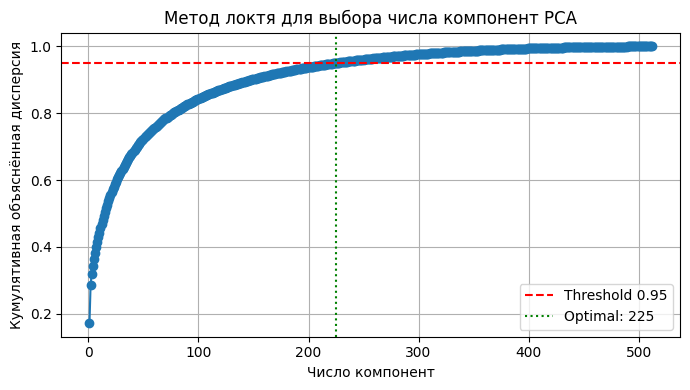

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def plot_pca_elbow(X, max_components=10000, threshold=0.95):
    pca = PCA(n_components=min(max_components, X.shape[1]))
    pca.fit(X)
    explained_var = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
    plt.xlabel('Число компонент')
    plt.ylabel('Кумулятивная объяснённая дисперсия')
    plt.title('Метод локтя для выбора числа компонент PCA')
    plt.grid(True)
    plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold {threshold:.2f}')
    
    # Корректная обработка
    above = np.where(explained_var >= threshold)[0]
    if len(above) == 0:
        optimal_n = len(explained_var)
        plt.axvline(optimal_n, color='orange', linestyle=':', label=f'Нет компоненты с {threshold:.2f}')
    else:
        optimal_n = above[0] + 1
        plt.axvline(optimal_n, color='green', linestyle=':', label=f'Optimal: {optimal_n}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return optimal_n


opt_n  = plot_pca_elbow(image_embeds)

In [41]:
opt_n

225

In [24]:

n_components = max(2, opt_n)
pca = PCA(n_components=n_components)
image_embeds_pca = pca.fit_transform(image_embeds)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
image_embeds_2d = tsne.fit_transform(image_embeds_pca)

In [34]:
def visualise_embeddings(image_embeds_2d, image_df, split):

    unique_domains = sorted(image_df['domain'].unique())
    marker_list = ['o', 's', '^', 'D', 'P', '*', 'v', '<', '>', 'X']
    domain_to_marker = {d: marker_list[i % len(marker_list)] for i, d in enumerate(unique_domains)}

    plt.figure(figsize=(16, 12))
    legend_handles = []

    for domain_idx, domain in enumerate(unique_domains):
        domain_mask = image_df['domain'] == domain
        domain_idxs = np.where(domain_mask)[0]
        domain_marker = marker_list[domain_idx % len(marker_list)]


        domain_classes = image_df.loc[domain_mask, 'class_name'].unique()
        n_dom_classes = len(domain_classes)
        if n_dom_classes <= 20:
            domain_cmap = plt.cm.tab20
        elif n_dom_classes <= 256:
            domain_cmap = plt.cm.nipy_spectral
        else:
            base_colors = plt.cm.nipy_spectral(np.linspace(0, 1, 256))
            domain_cmap = lambda x: base_colors[x % 256]
        class_to_color = {c: domain_cmap(i / n_dom_classes) if callable(domain_cmap) else domain_cmap(i) 
                        for i, c in enumerate(domain_classes)}
        
        legend_loc="best"
        title = "t-SNE/PCA изображений по классам"
        
        colors = [class_to_color[c] for c in image_df.loc[domain_mask, 'class_name']]
        
        plt.scatter(
            image_embeds_2d[domain_idxs, 0],
            image_embeds_2d[domain_idxs, 1],
            c=colors,
            marker=domain_marker,
            label=domain,
            s=25,
            alpha=0.7,
            edgecolor='none'
        )
  
        import matplotlib.lines as mlines
        legend_handles.append(
            mlines.Line2D([], [], color='black', marker=domain_marker, linestyle='None', markersize=10, label=domain)
        )

    plt.legend(title="Domain", loc=legend_loc)
    plt.title(title)
    plt.show()


In [35]:
test_df = df[df['split'] == 'test'].reset_index(drop=True)
image_domains = test_df['domain'].tolist()  # домен для каждой картинки из теста
labels = test_df['class_name'].tolist()     # список названий классов для этих картинок

# Для текстовых эмбеддингов классов (крестиков)
# Присваиваем домен как наиболее часто встречающийся у этого класса
class_to_domain = df.groupby('class_name')['domain'].agg(lambda x: x.value_counts().idxmax()).to_dict()
class_names = list(class_to_domain.keys())
text_domains = [class_to_domain[cls] for cls in class_names]



domain_color_map = {
    "CUB_200_2011_split": "royalblue",
    "fungi_clef_2022_split": "orangered",
    "dtd_split": "goldenrod"
}
domain_marker_map = {
    "CUB_200_2011_split": "o",
    "fungi_clef_2022_split": "s",
    "dtd_split": "D"
}


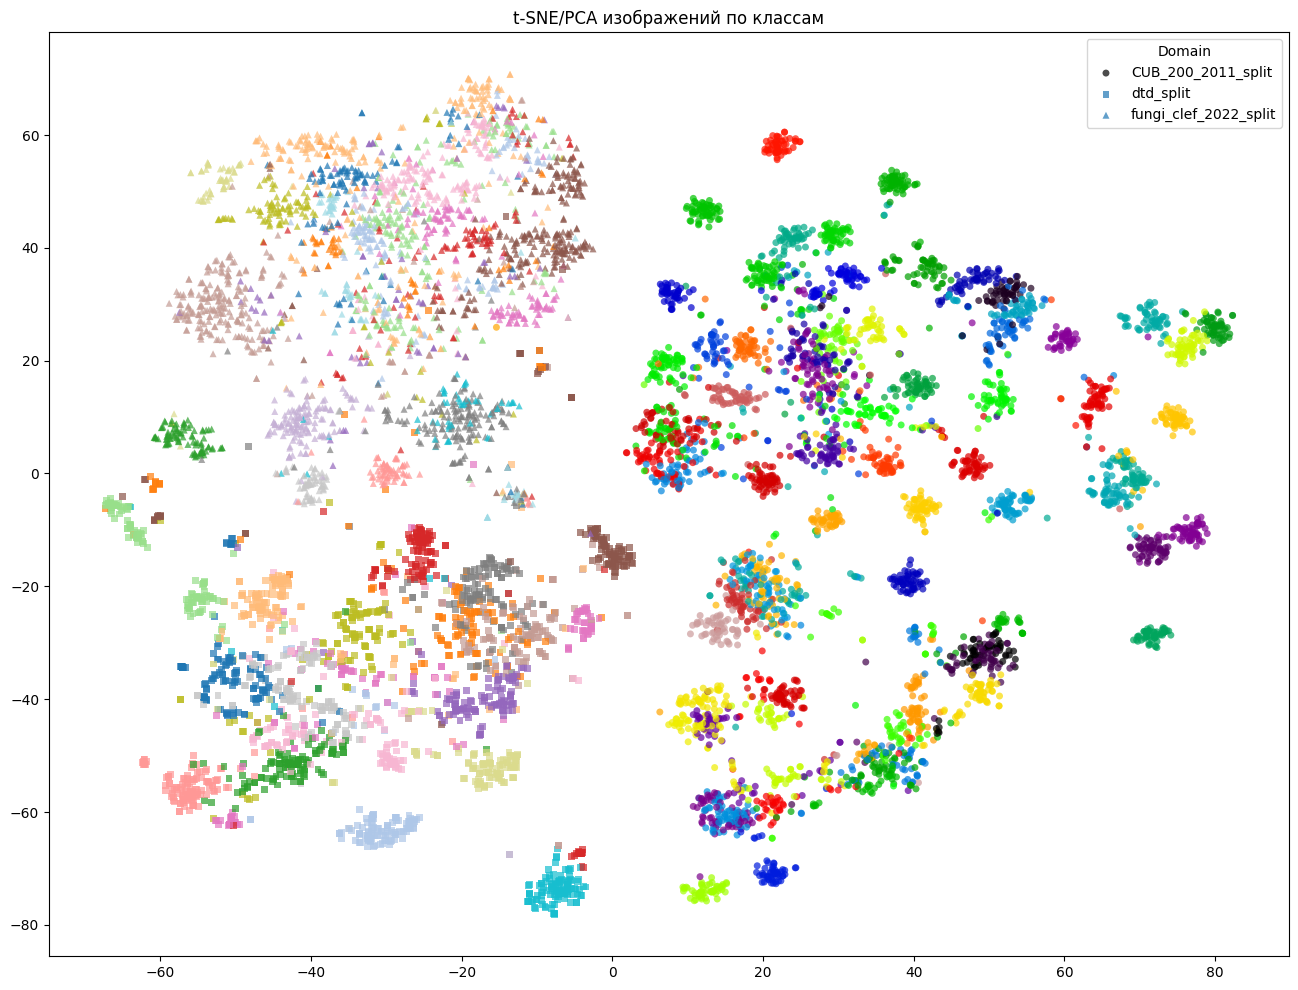

In [36]:
visualise_embeddings(image_embeds_2d, test_df, 'test')

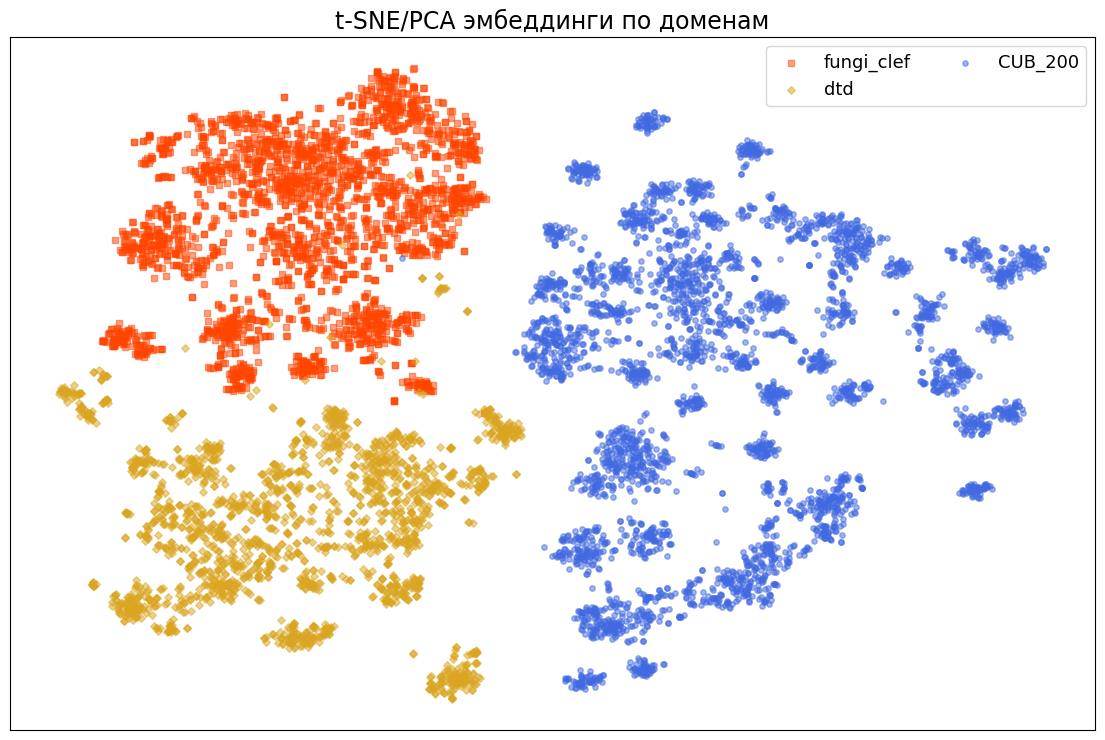

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 9))


unique_domains = set(image_domains)
plt.xticks([])
plt.yticks([])

for domain in unique_domains:
    mask = [d == domain for d in image_domains]
    plt.scatter(
        np.array(image_embeds_2d)[mask, 0],
        np.array(image_embeds_2d)[mask, 1],
        c=domain_color_map.get(domain, "gray"),
        label=f"{domain.rsplit('_', 2)[0]}",
        alpha=0.5,
        marker=domain_marker_map.get(domain, "x"),
        s=15
    )
plt.legend(fontsize=13, loc="best", ncol=2)
plt.title("t-SNE/PCA эмбеддинги по доменам", fontsize=17)
plt.show()